In [332]:
import os.path
import numpy as np
from numpy import linalg as la
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.animation as animate
# for vscode, use 'ipympl' for animations and 'inline', otherwise
# for browser, use 'notebook'
# %matplotlib ipympl
%matplotlib inline
# this is for colorbars on subplots
from mpl_toolkits.axes_grid1 import make_axes_locatable
# for rendering latex
from IPython.display import display, Math, Latex
import matplotlib.font_manager
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"]})

fname = "../data/particles.txt"
if os.path.isfile(fname):
    abc = 1
else:
    fname = "../data/particles1.txt"

f_ens = "../data/ens.txt"

In [333]:
with open(f_ens) as f:
    N_ens = int(f.readline())
    
with open(fname) as f:
    shapeData = f.readline()
    dim = int(f.readline())
    p = f.readline()

omega = np.zeros(2);

params = p.split()
IC_type_space = float(params[0])
IC_type_mass = float(params[1])
omega[0]= float(params[2])
omega[1]= float(params[3])
X0_space = float(params[4])
hat_pct = float(params[5])
X0_mass = float(params[6])
maxT = float(params[7])
dt = float(params[8])
D = float(params[9])
pctRW = float(params[10])
cdist_coeff = float(params[11])
cutdist = float(params[12])

In [334]:
# delta IC
sigma = 0.0

shapeData = shapeData.split()
shapeData = [int(i) for i in shapeData]
Np = shapeData[0]
Nsteps = shapeData[1] + 1

In [335]:
X = np.ndarray((Np, Nsteps))

for e in range(1, N_ens):
    fname_ens = "../data/particles" + str(e) + ".txt"
    with open(fname_ens) as f:
        data = np.loadtxt(f, skiprows=3)
        for i in range(10):
            tmpX = np.reshape(data[:, 0], (Np, Nsteps), 'f')
            if i == 0:
                X = tmpX
            else:
                X = np.concatenate((X, tmpX))
# sort spatially for comparison later              
X.sort(axis=0)

In [337]:
L = omega[1] - omega[0]

def analytic1d(X, t, sigma, D, L):
    sol =  (1 / np.sqrt(2 * np.pi * (sigma + 2 * D * t)))\
        * np.exp(-((0.5 * L - X[:])**2 / (2 * (sigma + 2 * D * t))));
    return sol

def analytic2d(dim, X, Y, t, sigma, D, L):
    sol =  (1 / np.power(2 * np.pi * (sigma + 2 * D * t), float(dim) / 2.0))\
           * np.exp(-(((0.5 * L - X)**2 + (0.5 * L - Y)**2)/ (2 * (sigma + 2 * D * t))));
    return sol

In [338]:
# number of histogram bins
# FIXME: better way to do this?
# nBins = int(np.floor(np.sqrt(Np))) + 1
# nBins = int(np.floor(max(X[:, -1]) - min(X[:, -1])) * 3)

Text(0.5, 1.0, 'Initial')

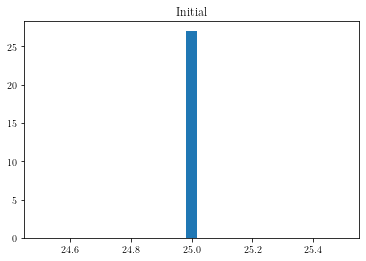

In [339]:
# plot the initial condition
fig = plt.figure()
(counts, bins, patches) = plt.hist(X[:, 0], density=True, bins=nBins)
plt.title('Initial')

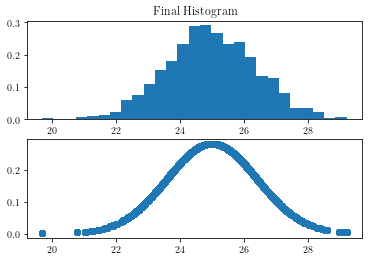

0.2911776769706408
0.28209470368217077
sample mean = 24.964417036967244
sample sigma =  1.423376267133489
true mean = sqrt(2 D maxT) = 25.0
true sigma = sqrt(2 D maxT) = 1.4142135623730951


In [340]:
asoln = analytic1d(X[:, -1], maxT, sigma, D, L)
fig = plt.figure()
plt.subplot(211)
plt.title('Final Histogram')
(counts, bins, patches) = plt.hist(X[:, -1], bins=nBins,
                                       weights=np.ones(np.shape(X[:, -1]))*
                                                       (1 / N_ens), density=True)
# (counts, bins, patches) = plt.hist(X[:, -1], bins=nBins, density=True)
# plt.hist()
plt.subplot(212)
plt.scatter(X[:, -1], asoln)
plt.show()
print(max(counts))
print(max(asoln))
print('sample mean = {}'.format(np.mean(X[:, -1])))
print('sample sigma =  {}'.format(np.std(X[:, -1])))
print('true mean = sqrt(2 D maxT) = {}'.format(X0_space))
print('true sigma = sqrt(2 D maxT) = {}'.format(np.sqrt(2.0 * D * maxT)))

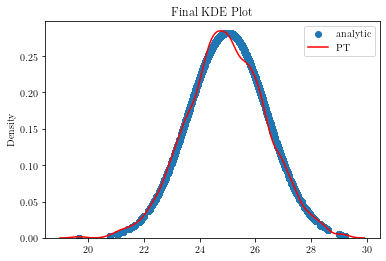

In [341]:
fig = plt.figure()
plt.title('Final KDE Plot')
plt.scatter(X[:, -1], asoln, label='analytic')
sns.kdeplot(X[:, -1], label='PT', color='r')
plt.legend()

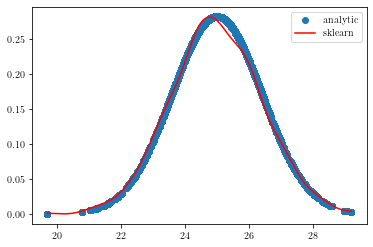

In [346]:
from sklearn.neighbors import KernelDensity

Z = np.array(X[:, -1])[:, np.newaxis]
# xplot = np.linspace(min(X[:, -1]), max(X[:, -1]), len(X[:, -1]))[:, np.newaxis]
xplot = np.linspace(min(X[:, -1]), max(X[:, -1]), 1000)[:, np.newaxis]
kde = KernelDensity(kernel="gaussian", bandwidth=0.3).fit(Z)
log_dens = kde.score_samples(xplot)
fig = plt.figure()
plt.scatter(X[:, -1], asoln, label='analytic')
plt.plot(xplot[:, 0], np.exp(log_dens), label='sklearn', color='r')
# sns.kdeplot(X[:, -1], label='seaborn', color='g')
plt.legend()

# la.norm(np.exp(log_dens) - asoln)

MSE = 0.012278199507018825
max analytic = 0.28209470368217077
max fitted = 0.2802788605280653
fitted: mu, sigma = 24.964417036967244, 1.423376267133489
particle: mean, std. [sqrt(2 D maxT)]  = 25.0, 1.4142135623730951
true sigma [sqrt(2 D maxT)] = 1.4142135623730951

MSE = 0.012278199507018825
error in max val = 0.0018158431541054898
error in mean, std. = 0.035582963032755544, 0.009162704760393936


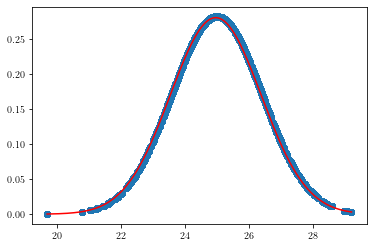

In [350]:
from scipy.stats import norm

xplot = np.linspace(min(X[:, -1]), max(X[:, -1]), len(X[:, -1]))
# xplot = np.linspace(min(X[:, -1]), max(X[:, -1]), 1000)
mu, sigma = norm.fit(X[:, -1])
p = norm.pdf(xplot, mu, sigma)
plt.scatter(X[:, -1], asoln)
plt.plot(xplot, p, color='r')

# print('2-norm error = {}'.format(la.norm(asoln - p)))
# print('inf-norm error = {}'.format(la.norm(abs(asoln - p), np.inf)))
print('max analytic = {}'.format(max(asoln)))
print('max fitted = {}'.format(max(p)))
print('fitted: mu, sigma = {}, {}'.format(mu, sigma))
print('particle: mean, std. [sqrt(2 D maxT)]  = {}, {}'.format(X0_space, np.sqrt(2.0 * D * maxT)))
print('true sigma [sqrt(2 D maxT)] = {}\n'.format(np.sqrt(2.0 * D * maxT)))

print('MSE = {}'.format(np.mean((asoln - p)**2)))
print('error in max val = {}'.format(abs(max(asoln) - max(p))))
print('error in mean, std. = {}, {}'.format(abs(mu - X0_space),
                                        abs(sigma - np.sqrt(2.0 * D * maxT))))

In [345]:
# def histAnimation(frame):
#     if frame == framesNum:
#         plt.close(fig)
#     else:
#         plt.cla()
#         p = plt.hist(X[0, :, frame], density=True, bins=20)

# # plot the animation
# fig = plt.figure()
# ani = animate.FuncAnimation(fig, histAnimation, frames=framesNum + 1)